# Spatiotemporal analysis of synthetic data
<br>

This notebook gives some examples of spatiotemporal analysis that we can conduct using `eggplant`'s framework. To demonstrate this we generate some synthetic data and then analyze it. In large it encompasses four main steps:

1. Generation of time series data using a dynamical system based on ODEs
2. Generation of spatial synthetic data based on time series data
3. Transfer of data to a common reference
4. Estimation of system parameters from transferred data

Import libraries

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.integrate import odeint
from PIL import Image


import anndata as ad
import pandas as pd
import sys
import os.path as osp


import eggplant as eg

from eggplant import ode

In [16]:
SAVE_MODE = False

## 1. Generation of time series data using a dynamical system based on ODEs

Configure figure settings

In [3]:
rcParams["figure.facecolor"] = "none"
rcParams["axes.facecolor"] = "none"

set random seed, for reproducibility

In [4]:
np.random.seed(27)

Define model parameters, according to:
\begin{equation}
\begin{bmatrix}
r_{11} & r_{12}\\
r_{21} & r_{22}
\end{bmatrix}
\end{equation}

In [5]:
n_regions = 2
rs = np.array([[0.2,0.8],[0.1,-0.3]])
rs

array([[ 0.2,  0.8],
       [ 0.1, -0.3]])

set initial values $\boldsymbol{x}(0) = (x_1(0),x_2(0)) = (5000,100)$


In [6]:
x0 = np.array([5000,100])

Define model dynamics, according to:
\begin{equation}
  \begin{array}{l} \frac{dc_{1}}{dt} = (r_{11}-r_{12})c_1 + r_{21}c_2\\[4pt]
\frac{dc_{2}}{dt} = (r_{22}-r_{21})c_2 + r_{12}c_1\\
  \end{array}
  \label{eq:dynamics}
\end{equation}<br>
and propagate in time, i.e., solving the system over the time points $\mathcal{T} = \{t : t \in [0,1000], t \textrm{ mod } 5 = 0\}$.

In [7]:
ode_fun = ode.make_ode_fun(n_regions = 2)
time = np.linspace(0,5,1000)
soln = odeint(ode_fun,x0,time,args = (rs,))

Visualize system over time

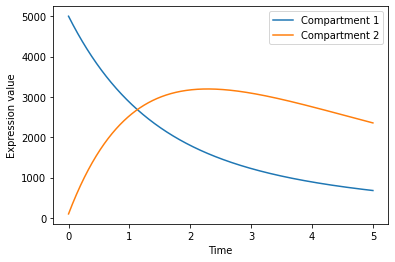

In [8]:
plt.plot(time,
         soln[:,0],
         label = "Compartment 1",
        )
plt.plot(time,
         soln[:,1],
         label = "Compartment 2",
        )

plt.ylabel("Expression value")
plt.xlabel("Time")
plt.legend()
plt.show()

Check that the ODE solver works when presented with full data; this is more a check of the solver implementation than anything else.

In [9]:
odeS = ode.ODE_solver(time,
                      soln,
                      x0,
                      ode_fun,
                      )

prms = odeS.optim(np.zeros(n_regions*n_regions))

We reshape the inferred parameters (solver does not work with 2d arrays) and then compare it with the true parameter values

In [10]:
rs_pred = prms["x"].reshape(n_regions,n_regions)

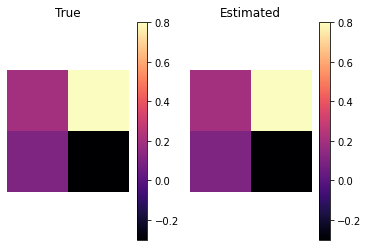

In [11]:
vmin = min(rs_pred.min(),rs.min())
vmax = max(rs_pred.max(),rs.max())
plt.subplot(121)
im1 = plt.imshow(rs,vmin = vmin,vmax = vmax,cmap = plt.cm.magma)
plt.colorbar(im1,)
plt.axis("equal")
plt.axis("off")
plt.title("True")
plt.subplot(122)
im2 = plt.imshow(rs_pred,vmin = vmin,vmax = vmax,cmap = plt.cm.magma)
plt.colorbar(im2)
plt.axis("equal")
plt.axis("off")
plt.title("Estimated")
plt.show()

Everything looks good, and we can proceed to construct the synthetic data

## 2. Generation of spatial synthetic data based on time series data

We define the paths to the templates used for the synthetic data and their landmark annotations.

In [12]:
SYN_DIR = "../../../data/synthetic/"
img_paths = [osp.join(SYN_DIR,"templates","imgs","t_{}.png".format(x)) for x in range(0,8)]
lmk_paths = [osp.join(SYN_DIR,"templates","landmarks","t_{}_landmarks.tsv".format(x)) for x in range(0,8)]

We next load each template and its corresponding landmark annotations. Each template is assigned to one time points and we distribute the number of transcripts between each compartment according to the system dynamics. Since we are using two compartments (marked in different colors in the reference), we set `n_regions=2`, we will again use approximately 1000 points in our reference grid.

In [13]:
from PIL import Image
sel_times = np.linspace(0,int(len(time) / 2),8).round().astype(int)
new_int_soln = soln
crds = list()
counts = list()
lmks = list()
for ii,(img_pth,lmk_pth,t) in enumerate(zip(img_paths,
                                            lmk_paths,sel_times)):
    lmk = pd.read_csv(lmk_pth,
                      sep = "\t",
                      header = 0,
                      index_col = 0)
    lmks.append(lmk)
    img = Image.open(img_pth)
    crd,meta = eg.pp.reference_to_grid(img,
                                      n_approx_points=1000,
                                      background_color="white",
                                      n_regions=2,
                                      )
    
    count = np.zeros(crd.shape[0])

    for k,reg in enumerate(np.unique(meta)):
        idx = np.where(meta == reg)[0]
        size = int(new_int_soln[t,k])
        sel = np.random.choice(idx,
                               replace = True,
                               size = size)
        for s in sel:
            count[s] +=1
            
    crds.append(crd)
    counts.append(count)

Next, we convert the count matrices and landmark data into `AnnData` objects that are easy to operate with and compatible with the `eggplant` API.

In [14]:
adatas = []
for k in range(len(crds)):
    obs_index = [f"Spot_{x}" for x in range(len(crds[k]))]
    adata = ad.AnnData(counts[k][:,np.newaxis],
                       var = pd.DataFrame(["Gene1"],
                                          columns = ["Gene"],
                                          index = ["Gene1"],
                                         ),
                       obs = pd.DataFrame(index = obs_index)
                      )
    adata.obsm["spatial"] = crds[k]
    adata.uns["curated_landmarks"] = lmks[k]
    eg.pp.get_landmark_distance(adata)
    adatas.append(adata)

We visualize the generated data to check that everything is in order. The visualization below is the raw images used to assemble Figure 1B in the manuscript, hence why the colorbar is in a seprate figure and no titles are included.

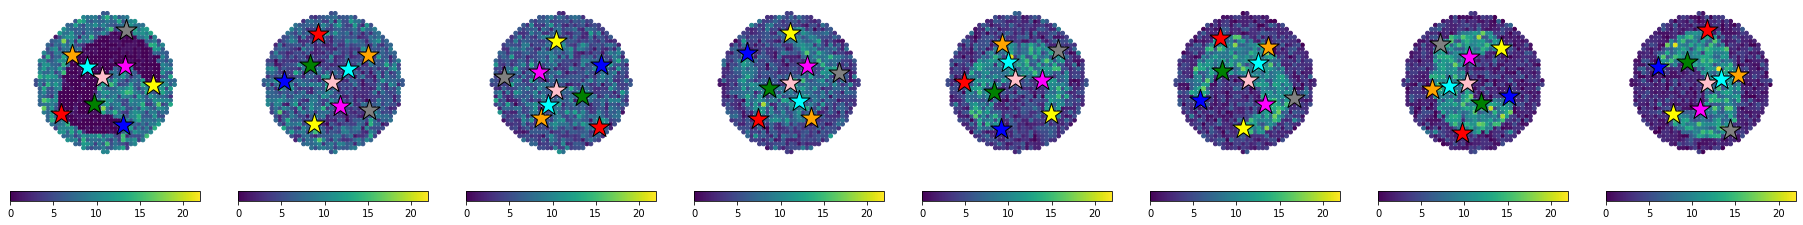

In [18]:
eg.pl.visualize_observed(adatas,
                         features="Gene1",
                         quantile_scaling = False,
                         n_rows = 1,
                         separate_colorbar = False,
                         include_title = False,
                         marker_size = 15,
                         colorbar_fontsize = 10,
                        )

## 3. Transfer of data to a common reference

We begin the transfer by reading in the reference template and its associated landmarks

In [19]:
ref_lmk_pth = osp.join(SYN_DIR,"references","landmarks.tsv")
ref_img_pth = osp.join(SYN_DIR,"references","reference.png")
ref_lmk = pd.read_csv(ref_lmk_pth,sep = "\t",header = 0,index_col = 0)
ref_img = Image.open(ref_img_pth)
ref_crd,ref_meta = eg.pp.reference_to_grid(ref_img,
                                           n_approx_points=1000,
                                           background_color="white",
                                           n_regions=2,
                                          )



Next we assemble a `Reference` object from the reference array data and landmarks. We also mathc the distances between our observed data and the reference, as well as compute landmark distances after correcting for non-homogenous distortions.

In [20]:
ref_lmk

,x_coord,y_coord
Landmark_0,412.176,663.138
Landmark_1,109.692,513.558
Landmark_2,234.342,174.510
Landmark_3,268.413,394.725
Landmark_4,404.697,438.768
Landmark_5,570.897,383.922
Landmark_6,564.249,174.510
Landmark_7,716.322,520.206
Landmark_8,405.528,541.812


In [21]:
ref = eg.m.Reference(ref_crd,
                     landmarks = ref_lmk,
                    )

for adata in adatas:
    eg.pp.match_scales(adata,ref)
    eg.pp.get_landmark_distance(adata,
                                reference=ref)


Finally, we can conduct the transfer from the observed data to the reference

In [22]:
!export CUDA_VISIBLE_DEVICES=0 

In [23]:
losses = eg.fun.transfer_to_reference(adatas,
                                      "Gene1",
                                      ref,
                                      device = "gpu",
                                      n_epochs=1000,
                                      verbose = True,
                                      return_models =False,
                                      return_losses = True,
                                      )

[Processing] ::  Model : Model_0 | Feature : Gene1 | Transfer : 1/8


/home/alma.andersson/miniconda3/envs/eggplant2/lib/python3.8/site-packages/eggplant-0.1-py3.8.egg/eggplant/models.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ldists = t.tensor(landmark_distances)
/home/alma.andersson/miniconda3/envs/eggplant2/lib/python3.8/site-packages/eggplant-0.1-py3.8.egg/eggplant/models.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = t.tensor(feature_values)
  0%|                                                                                                                         | 0/1000 [00:00<?, ?it/s]/home/alma.andersson/miniconda3/envs/eggplant2/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:266: UserWarning: An out

[Processing] ::  Model : Model_1 | Feature : Gene1 | Transfer : 2/8


/home/alma.andersson/miniconda3/envs/eggplant2/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.96it/s]


[Processing] ::  Model : Model_2 | Feature : Gene1 | Transfer : 3/8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.66it/s]


[Processing] ::  Model : Model_3 | Feature : Gene1 | Transfer : 4/8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.77it/s]


[Processing] ::  Model : Model_4 | Feature : Gene1 | Transfer : 5/8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.04it/s]


[Processing] ::  Model : Model_5 | Feature : Gene1 | Transfer : 6/8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 41.67it/s]


[Processing] ::  Model : Model_6 | Feature : Gene1 | Transfer : 7/8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.41it/s]


[Processing] ::  Model : Model_7 | Feature : Gene1 | Transfer : 8/8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.88it/s]


Let us check the loss curves to make sure that the models converge and that nothing unexpected happened.

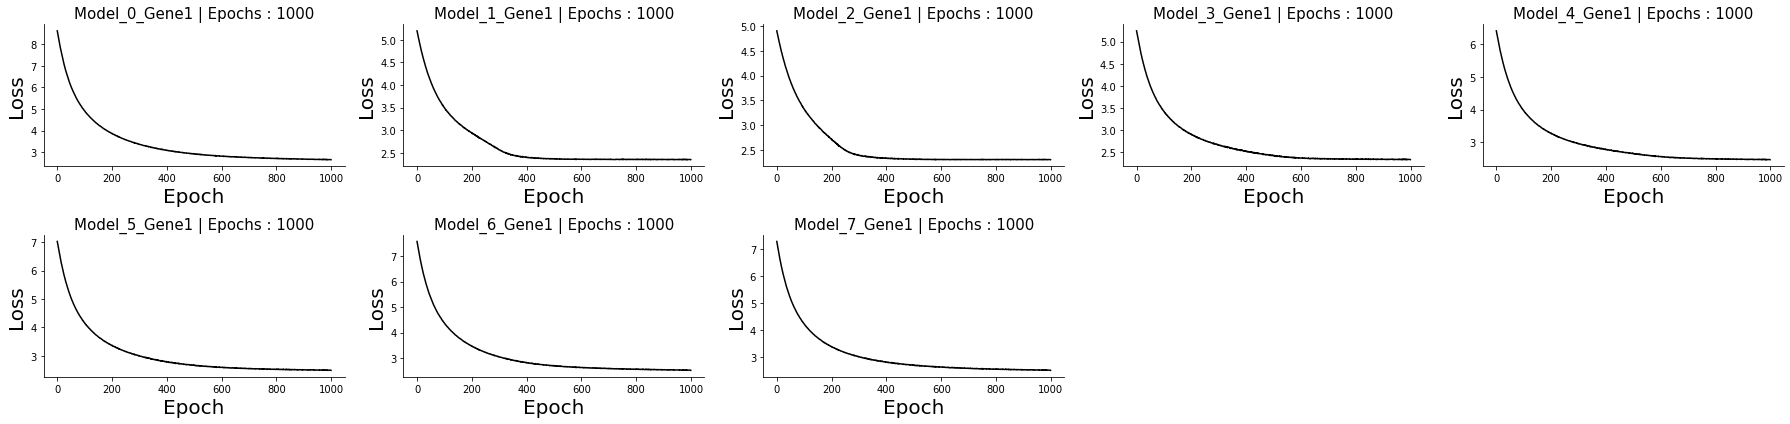

In [24]:
eg.pl.model_diagnostics(losses = losses)

Since everything looks as expected, we proceed to visualize the results spatially.

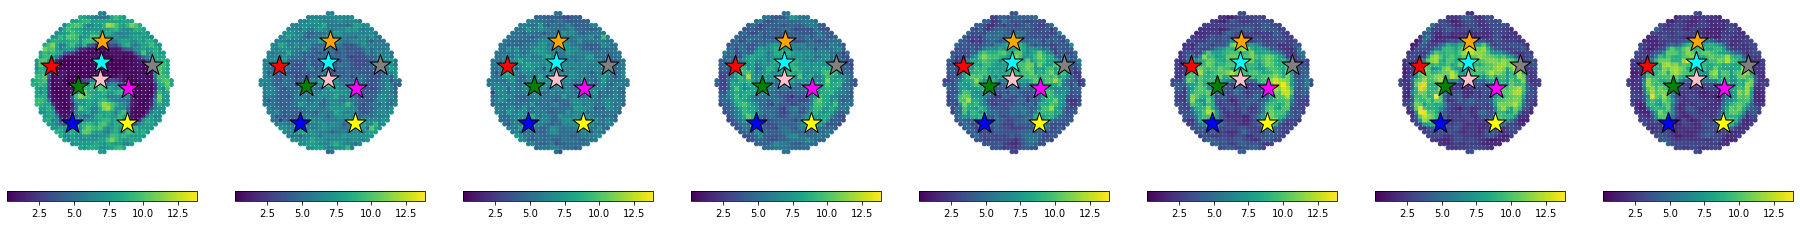

In [26]:
eg.pl.visualize_transfer(ref,
                         marker_size = 15,
                         separate_colorbar=False,
                         n_rows = 1,
                         include_title =False,
                         colorbar_fontsize = 10,
                        )

## 4. Estimation of system parameters from transferred data

### Parameter estimation

In the spatiotemporal analysis we try to infer the rate parameters $(r_{11},r_{12},r_{21},r_{22})$ from the transferred data. Since we know the character of the systems dynamics, this becomes a task of fitting a model to the data. However, the very fist thing we need to do is to aggregate the expected number of transcripts in each compartment (C1 and C2), which we do below. 

In [28]:
time_data = np.zeros((len(adatas),n_regions))

for t in range(len(adatas)):
    for k,reg in enumerate([0,1]):
        idx = ref_meta == reg
        time_data[t,k] = np.sum(ref.adata.X[idx,t])

Next we apply the ODE solver using out aggregated data and the time points at which we sampled it from.

In [29]:
odes = ode.ODE_solver(time[sel_times],
                  time_data,
                  time_data[0,:],
                    ode_fun=ode_fun,
                  )

prms = odes.optim(np.zeros(n_regions*n_regions))

We then continue to solve the system using the estimated parameters

In [30]:
est_rs = prms["x"].reshape(n_regions,n_regions)
est_soln = odeint(ode_fun,
                  x0,
                  time,
                  args = (est_rs,),
                 )

Now we compare the true and estimated solution to see how well our estimates performed.

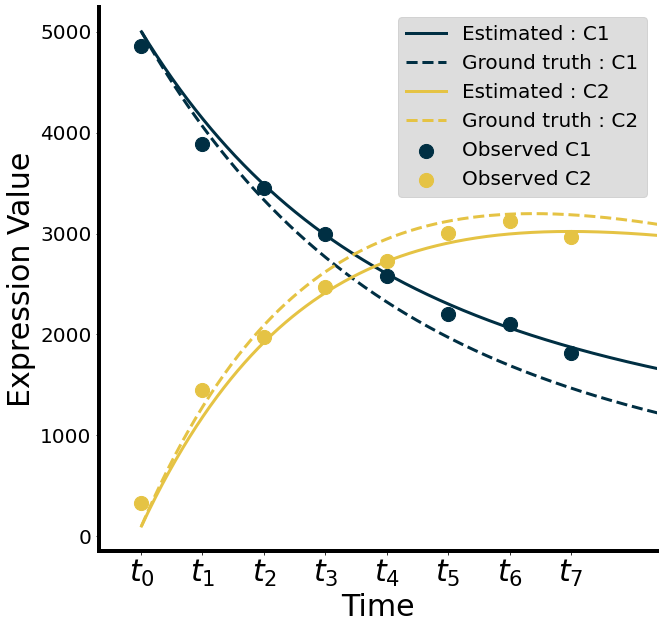

In [31]:
# Output used for Figure 2C
fig,ax = plt.subplots(1,1,figsize=(10,10))
for k,(clr,compname) in enumerate(zip(["#002F43","#E5C344"],
                             ["C1","C2"])):
    
    ax.scatter(sel_times,
           time_data[:,k],
           c = clr,
           s = 200,
           label = "Observed " + compname,
           )
        
    for sol,linetype,solname in zip([est_soln,soln],
                                    ["solid","dashed"],
                                    ["Estimated","Ground truth"]):
   
        ax.plot(sol[:,k],
                color = clr,
                linestyle = linetype,
                label = solname + " : " + compname,
                linewidth = 3,
               )
    
ax.set_xticks(sel_times)
ax.set_xticklabels([r"$t_{}$".format(k) for k in range(len(sel_times))],
                 fontsize = 30.
                 )

plt.setp(ax.get_yticklabels(), fontsize=20)                                       

ax.legend(fontsize = 20, facecolor ="#D5D5D5")
ax.set_ylabel("Expression Value",fontsize = 30)
ax.set_xlabel("Time",fontsize = 30)
[i.set_linewidth(4) for i in ax.spines.values()]
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim([-50,600])

if SAVE_MODE: plt.savefig(osp.join(RES_DIR,"synthetic-1-system.png"))
plt.show()


### Spatial Arithmetics 

Our final analysis will be swift and simple, yet effectful. We will conduct what is here referred to as _spatial arithmetics_. More precisely this procedure allows us to highlight local difference between time points or conditions in the feature that we've mapped to our reference; in our case this  will evidently be over time points<br>
<br>
In practice, since our data have been transferred to the same reference we can simply subtract the values of one location at $t_1$ from the values at the very same location at $t_2$, and we'll be able to see how the feature of interest differs in this region between the two time points. If we do this for every point in the reference array, we'll end up with a map of local changes, providing a global overview.<br>
<br>
We'll look at the local changes between the first and lost time point here.

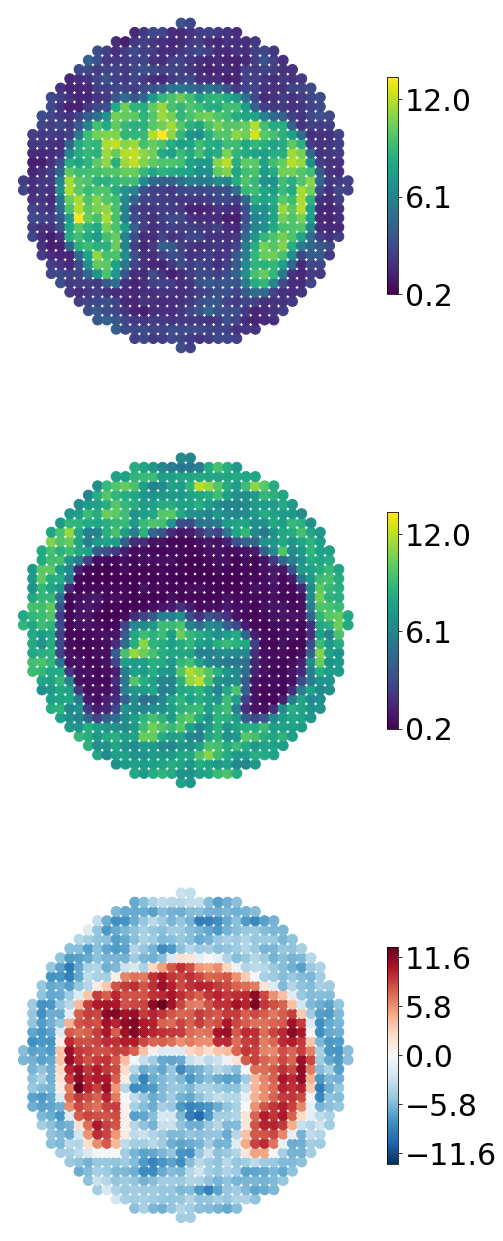

In [32]:
# Output used in Figure 1D
fig,ax = plt.subplots(3,1,figsize = (8,24))
ax = ax.flatten()
art_sel = [-1,0]
vmin = ref.adata.X[:,art_sel].min()
vmax = ref.adata.X[:,art_sel].max()
cticks = np.linspace(vmin * 1.1,vmax * 0.9,3).round(1)

marker_size = 100
cbar_fontsize = 30
art_cmaps = [plt.cm.Reds,plt.cm.Blues]

for k,s in enumerate(art_sel):
    _sc = ax[k].scatter(ref_crd[:,0],
                        ref_crd[:,1],
                        c = ref.adata.X[:,s],
                        s = marker_size,
                        cmap = plt.cm.viridis,
                        marker = "o",
                        vmin = vmin,
                        vmax = vmax,
                       )
    
    cbar = fig.colorbar(_sc,ax = ax[k],shrink = 0.5,ticks=cticks)
    cbar.ax.tick_params(labelsize=cbar_fontsize)

    
diff = ref.adata.X[:,[art_sel[0]]] - ref.adata.X[:,[art_sel[1]]]
vmin = diff.min()
vmax = diff.max()

vmax = max(abs(vmin),abs(vmax))
vmin = -vmax

cticks= np.linspace(vmin + abs(0.1*vmax),vmax - 0.1*abs(vmax),5).round(1)
    
_sc = ax[2].scatter(ref_crd[:,0],
              ref_crd[:,1],
              c = diff ,
              s = marker_size,
              cmap = plt.cm.RdBu_r,
              marker = "o",
              vmin = vmin,
              vmax = vmax,
             )

cbar = fig.colorbar(_sc,
                    ax = ax[2],
                    shrink=0.5,
                    ticks=cticks)

cbar.ax.tick_params(labelsize=cbar_fontsize,)


for aa in ax:
    aa.set_aspect("equal")
    aa.axis("off")


plt.subplots_adjust(hspace = 0.0001)
plt.show()